# Step 7: Model Testing Pipeline
This notebook loads the final model and test set from W&B, evaluates predictions, tunes the threshold for best F1 score, and logs both default and optimized metrics back to W&B.

In [43]:
!pip install -q wandb joblib scikit-learn matplotlib seaborn


[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [44]:
import pandas as pd
import numpy as np
import joblib
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

## 1. Load data and model

In [45]:
def load_model_and_data():
    run = wandb.init(project="diabetes", job_type="test", entity="ngocnhi-p4work-national-economics-university")
    artifact = run.use_artifact("final_model.pkl:latest", type="model")
    artifact_path = artifact.download()
    model_path = f"{artifact_path}/final_model.pkl"

    model, scaler = joblib.load(model_path)
    print("✅ Model loaded:", model)
    
    artifact_data = run.use_artifact("test.csv:latest", type="segregated_data")
    test_data_path = artifact_data.download()
    df_test = pd.read_csv(f"{test_data_path}/test.csv")
    X_test = df_test.drop("OUTCOME", axis=1)
    y_test = df_test["OUTCOME"]
    return model, scaler, X_test, y_test, run

## 2. Train test data with default threshold

In [46]:
def evaluate_default_threshold(model, X_test, y_test):
    X_test_scaled = scaler.transform(X_test)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    print(f"Accuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1 Score: {f1:.4f}\nAUC: {auc:.4f}")
    return y_pred, y_proba, accuracy, precision, recall, f1, auc

## 3. Train test data with tuned threshold

In [47]:
def tune_threshold(y_test, y_proba):
    thresholds = np.arange(0.1, 0.91, 0.01)
    f1_scores, precisions, recalls = [], [], []
    for thresh in thresholds:
        y_pred_thresh = (y_proba > thresh).astype(int)
        f1_scores.append(f1_score(y_test, y_pred_thresh))
        precisions.append(precision_score(y_test, y_pred_thresh))
        recalls.append(recall_score(y_test, y_pred_thresh))
    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_idx]
    print(f"✅ Best Threshold: {best_thresh:.2f}")
    print(f"F1: {f1_scores[best_idx]:.4f} | Precision: {precisions[best_idx]:.4f} | Recall: {recalls[best_idx]:.4f}")
    return best_thresh, f1_scores, precisions, recalls, thresholds

## 3. Plot Precision, Recall, F1 

In [48]:
def plot_thresholds(thresholds, f1_scores, precisions, recalls, best_thresh):
    plt.figure(figsize=(10,5))
    plt.plot(thresholds, f1_scores, label="F1 Score")
    plt.plot(thresholds, precisions, label="Precision", linestyle="--")
    plt.plot(thresholds, recalls, label="Recall", linestyle="--")
    plt.axvline(best_thresh, color='r', linestyle=':', label=f'Best Threshold = {best_thresh:.2f}')
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Threshold Tuning for F1 Optimization")
    plt.legend()
    plt.grid(True)
    plt.show()

## 4. Evaluate with the tuned threshold

In [49]:
def evaluate_with_best_threshold(y_test, y_proba, best_thresh):
    y_pred_opt = (y_proba > best_thresh).astype(int)
    f1_opt = f1_score(y_test, y_pred_opt)
    precision_opt = precision_score(y_test, y_pred_opt)
    recall_opt = recall_score(y_test, y_pred_opt)
    print("✅ Metrics with Tuned Threshold:")
    print(f"F1 Score: {f1_opt:.4f}\nPrecision: {precision_opt:.4f}\nRecall: {recall_opt:.4f}")
    return y_pred_opt, f1_opt, precision_opt, recall_opt

In [50]:
def plot_confusion_and_roc(y_test, y_pred, y_proba, auc):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

## 5. Log to wandb the defauld evaluation and the tuned-threshold evaluation

In [51]:
def log_to_wandb(run, best_thresh, f1_opt, precision_opt, recall_opt, 
                 accuracy, precision, recall, f1, auc):
    run.log({
        "tuned_threshold": best_thresh,
        "f1_tuned": f1_opt,
        "precision_tuned": precision_opt,
        "recall_tuned": recall_opt,
        "accuracy_default": accuracy,
        "precision_default": precision,
        "recall_default": recall,
        "f1_default": f1,
        "auc": auc
    })

wandb:   1 of 1 files downloaded.  


✅ Model loaded: RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=6,
                       n_estimators=96)


wandb:   1 of 1 files downloaded.  


Accuracy: 0.7403
Precision: 0.6154
Recall: 0.6914
F1 Score: 0.6512
AUC: 0.8394
✅ Best Threshold: 0.36
F1: 0.7282 | Precision: 0.6228 | Recall: 0.8765


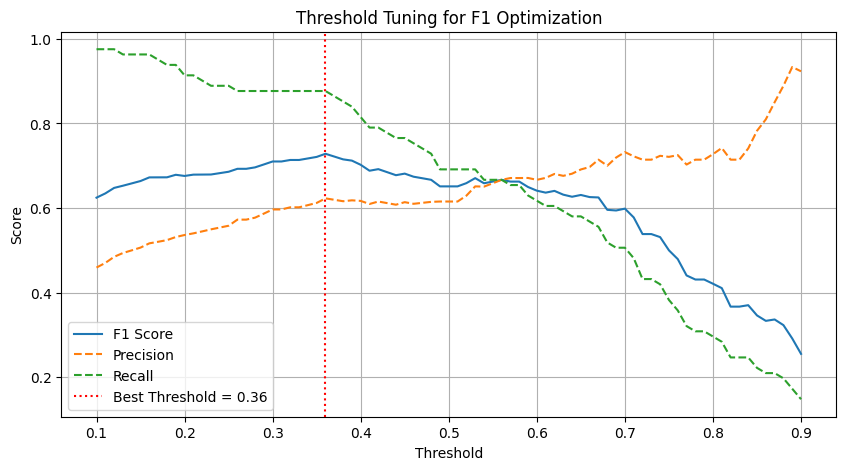

✅ Metrics with Tuned Threshold:
F1 Score: 0.7282
Precision: 0.6228
Recall: 0.8765


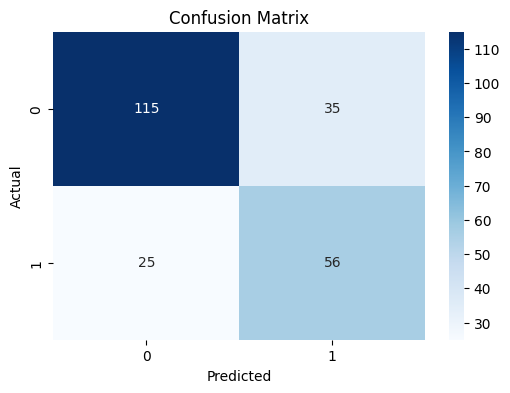

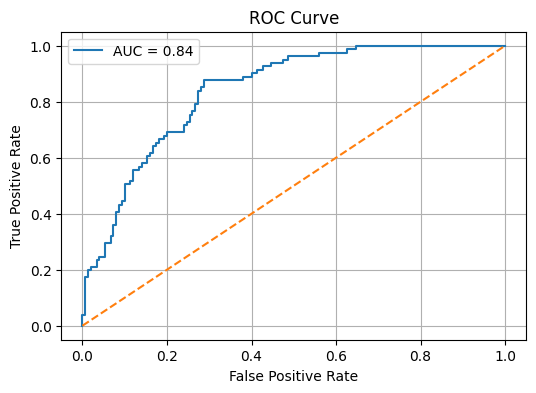

accuracy_default,▁
auc,▁
f1_default,▁
f1_tuned,▁
precision_default,▁
precision_tuned,▁
recall_default,▁
recall_tuned,▁
tuned_threshold,▁
accuracy_default,0.74026
auc,0.83942


In [52]:
# === RUN PIPELINE ===
model, scaler, X_test, y_test, run = load_model_and_data()
# Evaluate the model with default threshold
y_pred, y_proba, accuracy, precision, recall, f1, auc = evaluate_default_threshold(model, X_test, y_test)
# Tune the threshold for optimal F1 score
best_thresh, f1_scores, precisions, recalls, thresholds = tune_threshold(y_test, y_proba)
# Plot the thresholds and their corresponding scores
plot_thresholds(thresholds, f1_scores, precisions, recalls, best_thresh)
# Evaluate the model with the best threshold
y_pred_opt, f1_opt, precision_opt, recall_opt = evaluate_with_best_threshold(y_test, y_proba, best_thresh)
plot_confusion_and_roc(y_test, y_pred, y_proba, auc)
# Log the results to Weights & Biases
log_to_wandb(run, best_thresh, f1_opt, precision_opt, recall_opt, accuracy, precision, recall, f1, auc)
run.finish()